# 1. Data preparation

This is where every practical DreaMS project begins: converting your raw mass spectrometry data into a format that is efficient, robust, and ready for machine learning.  
In this notebook, we also **clean the data, apply quality control filters, and keep only single positive-charge mass spectra**, since DreaMS is designed to work on those.


In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# make PROJECT_ROOT available
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

# DreaMS imports
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

from dreams.utils.data import MSData
from dreams.utils.dformats import DataFormatA
from dreams.utils.spectra import unpad_peak_list
from dreams.utils.io import append_to_stem

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## 1.1 Loading and converting mass spectrometry data

In DreaMS, we use the `MSData` class to handle all spectral data. This object is your main interface for loading, exploring, filtering, and saving MS/MS spectra, and it works with the main mass spectrometry file formats: `.mzML` and `.mgf`.

### Why use MSData and HDF5?

- **Universal loader:** `MSData.load()` automatically detects your file type (`.mgf` or `.mzML`) and converts it into a single, easy-to-use object.
- **Automatic HDF5 conversion:** On the very first run, your data is converted to an HDF5 file, a binary format made for fast, large-scale access.
  - HDF5 makes it possible to access thousands of spectra rapidly
  - It uses much less disk space than text files
  - All metadata (precursor m/z, charge, SMILES, and more) is kept and easily accessible
- **Transparent caching:** Once converted, a `.hdf5` file will appear next to your original `.mgf` or `.mzML` file. All future loads will use this cached file, so you do not need to re-parse the text again.

For more details, see: [DreaMS documentation – Working with MS/MS data using HDF5](https://dreams-docs.readthedocs.io/en/latest/tutorials/msdata.html)

---

In [2]:
# If you want to use your own data, put the path to your file here.
# Be careful to use the full (absolute) path, or use PROJECT_ROOT as we do here.
spectra_path = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated.mgf"
h5_path      = spectra_path.with_suffix('.hdf5')

In [3]:
if h5_path.exists():
    # If the HDF5 already exists, load it directly (this is fastest)
    msdata = MSData.from_hdf5(h5_path, in_mem=True, prec_mz_col="PRECURSOR_MZ")
else:
    # If not, convert from the original file and cache the result as HDF5
    msdata = MSData.load(
        spectra_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )

Loading dataset Piper_sirius_all_annotated into memory (6732 spectra)...


After running this code for the first time, check your `data/` folder:  
A new `.hdf5` file with the same name as your input file will be created.

From now on, all data processing will use this **HDF5 file** as the source, it is much faster, and you do not need to worry about re-parsing files.

> **Tip:**  
> If you ever change the original `.mgf` or `.mzML`, just delete the `.hdf5` file and rerun this cell to regenerate it.

### 1.2 Inspecting your data with the `MSData` object

#### Check available columns and metadata

First, you can list all the columns (attributes) present in your dataset.  
These typically include the **precursor m/z**, **charge**, **file name**, and, if available, **SMILES**, **compound name**, and other metadata stored for each spectrum.

In [18]:

print("columns in MSData:", msdata.columns())

columns in MSData: ['COMPOUND_NAME', 'FEATURE_ID', 'FILE_NAME', 'FORMULA', 'INCHI', 'INCHIKEY', 'MS_LEVEL', 'NUM_PEAKS', 'RETENTION_TIME', 'SCANS', 'SPECTYPE', 'adduct', 'charge', 'precursor_mz', 'smiles', 'spectrum']


### Visualize a single spectrum and its metadata

You can quickly inspect the data and metadata for any individual spectrum by its index (here, we use the first spectrum at index 0):

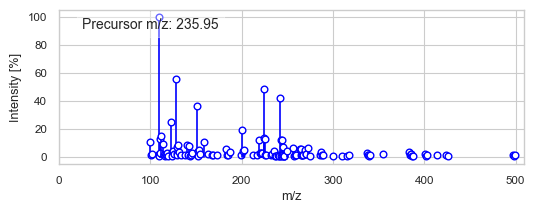

[19:47:05] SMILES Parse Error: syntax error while parsing: None
[19:47:05] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

{'COMPOUND_NAME': 'None',
 'FEATURE_ID': 1,
 'FILE_NAME': 'nan',
 'FORMULA': 'None',
 'INCHI': 'None',
 'INCHIKEY': 'None',
 'MS_LEVEL': 1,
 'NUM_PEAKS': 353,
 'RETENTION_TIME': 51.84,
 'SCANS': 1,
 'SPECTYPE': 'nan',
 'adduct': 'nan',
 'charge': '1+',
 'precursor_mz': 235.95248,
 'smiles': 'None'}

In [5]:
msdata.at(0)

Each spectrum in `MSData` not only contains the **peak list**, but also keeps track of its **source file**, the **scan number**, and all **annotation fields**.  
This is useful, later, you’ll always be able to trace any processed spectrum back to its origin.

#### Accessing the peak lists as arrays

`MSData` stores all your spectra as a single large **3D array** for efficiency.  
When you run:

In [6]:
spectra = msdata.get_spectra()  # numpy ndarray, shape (N, 2, P)
print(spectra.shape)

(6732, 2, 128)


You’ll get:

- **N**: number of spectra (e.g., 6732)  
- **2**: two arrays per spectrum (`m/z` and intensity)  
- **P**: each spectrum is padded to the same length for compatibility with ML models

For example, `spectra[0][0]` gives you the **m/z values** for the first spectrum, and `spectra[0][1]` gives the **corresponding intensities**.

In [21]:
spectra[0][1]

array([ 10.679,   1.504,   2.201, 100.   ,   1.943,   1.276,   1.007,
        12.638,   3.057,  14.635,   9.578,   1.633,   0.884,   1.127,
         2.155,   2.499,   0.825,  25.276,   3.402,   0.986,   4.123,
         2.212,  55.733,   2.817,   6.923,   1.512,   8.367,   3.66 ,
         1.11 ,   1.392,   8.575,   1.103,   7.668,   0.832,   1.504,
         2.711,  36.097,   3.924,   0.881,   5.191,   1.738,  10.895,
         1.742,   1.059,   1.405,   1.128,   5.681,   1.115,   1.554,
         3.517,   1.274,  19.271,   4.324,   5.026,   1.725,   1.28 ,
        11.817,   2.661,   3.128,   3.064,  48.429,  13.674,  13.031,
         1.075,   1.495,   1.13 ,   2.284,   4.444,   0.989,   0.979,
         1.681,   0.899,   0.952,  42.379,   0.797,  11.753,  11.764,
         0.855,   7.126,   1.631,   0.917,   0.781,   0.915,   3.956,
         6.234,   0.863,   1.695,   1.511,   5.46 ,   1.136,   5.687,
         1.023,   1.375,   1.504,   4.759,   1.755,   2.145,   6.464,
         0.915,   1.

#### Inspecting an individual spectrum (padded)

Let’s look at the raw, padded values for the first spectrum:

In [7]:
np.set_printoptions(precision=4, suppress=True)
print(spectra[0])

[[100.0244 101.0253 102.022  110.0088 110.0108 110.0123 110.0132 111.0096
  111.0118 112.0063 113.9638 114.9715 115.9642 116.9621 116.9663 118.0864
  119.0141 123.0404 124.0412 124.0437 125.038  125.9864 128.0194 128.9509
  129.0202 129.0226 130.0169 130.9665 134.0813 137.9872 139.9823 141.051
  141.9587 143.9591 144.957  146.0299 151.0354 152.0362 152.0387 153.0329
  153.9979 158.9615 162.9984 167.9774 169.0462 172.9776 182.963  183.9638
  184.9606 186.9566 198.9405 200.9735 201.9744 202.9711 212.9366 216.9512
  218.9841 219.9851 220.9818 221.9314 223.9896 224.9907 225.9872 225.993
  226.9885 231.9158 232.9235 235.9524 236.9532 237.9496 239.9671 240.9314
  240.9533 242.0001 242.9515 243.0013 243.9977 244.0036 244.9472 244.9989
  245.9482 245.995  246.9447 249.9262 255.9394 256.9407 258.9377 260.0106
  263.9474 264.9483 265.0161 265.9448 266.0173 267.0137 268.9485 269.9495
  270.9464 272.9424 274.9399 286.1446 286.9593 287.9602 288.9569 299.891
  309.9756 314.9544 317.9015 336.9016 337

You’ll see that some values at the end are zeros, these are just padding, so all spectra are the same size.

> **Note:**  
> These zeros will not influence DreaMS, they are ignored.

#### Remove padding to get the real peaks

To work with just the real (non-zero) peaks, use the `unpad_peak_list` function:

In [22]:
s0 = unpad_peak_list(spectra[0])
print(s0)  # shape (n_peaks, 2)

[[100.0244 101.0253 102.022  110.0088 110.0108 110.0123 110.0132 111.0096
  111.0118 112.0063 113.9638 114.9715 115.9642 116.9621 116.9663 118.0864
  119.0141 123.0404 124.0412 124.0437 125.038  125.9864 128.0194 128.9509
  129.0202 129.0226 130.0169 130.9665 134.0813 137.9872 139.9823 141.051
  141.9587 143.9591 144.957  146.0299 151.0354 152.0362 152.0387 153.0329
  153.9979 158.9615 162.9984 167.9774 169.0462 172.9776 182.963  183.9638
  184.9606 186.9566 198.9405 200.9735 201.9744 202.9711 212.9366 216.9512
  218.9841 219.9851 220.9818 221.9314 223.9896 224.9907 225.9872 225.993
  226.9885 231.9158 232.9235 235.9524 236.9532 237.9496 239.9671 240.9314
  240.9533 242.0001 242.9515 243.0013 243.9977 244.0036 244.9472 244.9989
  245.9482 245.995  246.9447 249.9262 255.9394 256.9407 258.9377 260.0106
  263.9474 264.9483 265.0161 265.9448 266.0173 267.0137 268.9485 269.9495
  270.9464 272.9424 274.9399 286.1446 286.9593 287.9602 288.9569 299.891
  309.9756 314.9544 317.9015 336.9016 337

### Accessing specific metadata values

The `MSData` object makes it easy to pull out metadata for all or just some spectra.  
For example, you can quickly check the **charge state** of each spectrum.

In [9]:
msdata.get_values('charge') 


['1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',

This gives you a list of charge states for every spectrum in your dataset.

**Get the value for a specific spectrum**

If you want just the charge of the first spectrum:

In [10]:
msdata.get_values('charge', [0])  

['1+']



You can also fetch, for example, the charge states for spectra 0 through 3:

In [11]:
msdata.get_values('charge', [0, 1, 2, 3])  

['1+', '1+', '1+', '1+']

### Filtering to single-charge positive-ion spectra only

DreaMS is designed specifically for spectra acquired in **single positive ionization mode (1+)**.  
While your data may also include **doubly-charged (2+)** or even higher, for this workflow we will keep only the **singly-charged spectra**.

In [23]:
# Get all charges (as strings, e.g. ['1+', '2+', '1+', '0'])
raw_charges = msdata.get_values("charge")

# Convert to integer charges: strip any '+' or '−', then convert to int
charges = np.array([int(''.join(ch.strip().rstrip('+-−'))) for ch in raw_charges])

# Keep only spectra with charge == 1
single_pos_idx = np.where(charges == 1)[0]
print(f"keeping {len(single_pos_idx)} / {len(charges)} spectra with charge == 1")

keeping 6720 / 6732 spectra with charge == 1


Depending on your data, the charge notation (`1+`, `2+`, etc.) might differ.  
**Always double-check** how charge is stored in your dataset and adjust your filter if needed.

Now, create a new `MSData` object with only the **singly-charged positive-ion spectra**, and save it as a new **HDF5 file**:

In [24]:
hq_h5 = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated_pos.hdf5"
msdata_pos = msdata.form_subset(single_pos_idx, out_pth=hq_h5)

This subset is what you will use for the next steps in **data cleaning** and **preparation**.

## This is requeired for QC 
We need to pull mass spectra and precursor mz for quality control and it have to be in shape of (M, 2, P) and (M,), you do not need to care, it is solved internaly.
# TODO add image here

In [15]:
# 6) pull out spectra & precursor m/z arrays (unpadded!)
spectra = msdata_pos.get_spectra()    # (M, 2, P) padded
prec_mzs = msdata_pos.get_prec_mzs()  # (M,)

# unpad each spectrum before any intensity‐based checks
spectra = [ unpad_peak_list(s) for s in spectra ]

In [16]:
# 7) compute single‐spectrum QC flags
dformat      = DataFormatA()
quality_lvls = [
    dformat.val_spec(spec, prec, return_problems=True)
    for spec, prec in zip(spectra, prec_mzs)
]

# tally results
pd.Series(quality_lvls).value_counts()

All checks passed                      4768
Number of high intensity peaks >= 3     955
Intensity amplitude >= 20.0             943
Number of peaks between 3 and 128        61
m/z range <= 1000.0                       5
Name: count, dtype: int64

## so now we are preserving 2000 mass spectra, rest will be removed 

In [17]:
# 8) keep only those that passed *all* metrics
pass_idx = np.where(np.array(quality_lvls) == "All checks passed")[0]
print(f"{len(pass_idx)} spectra passed all QC out of {len(quality_lvls)}")

clean_h5 = append_to_stem(h5_path, "high_quality")
msdata_hq = msdata_pos.form_subset(pass_idx, out_pth=clean_h5)
print(msdata_hq)

4768 spectra passed all QC out of 6732
MSData(pth=/Users/macbook/CODE/DreaMS_MIMB/data/Piper_sirius_all_annotated_high_quality.hdf5, in_mem=False) with 4,768 spectra.


## Next
**Next:** you now have a clean, positive‐ion, high‐quality HDF5 for downstream embedding and clustering.  
Proceed to **2_lsh_and_clustering.ipynb** for LSH deduplication & DreamS encoding.